# Computing product ease of assembly with NLP
In this notebook we'll be:
1. Reading in some labeled data
2. Preprocess the data for each intended model
3. Splitting the data into test/train sets   
4. Embed a few models on the train set (BoW, word2vec, doc2vec, I'll add BERT later)
5. Averaging the word vectors for each sentence
6. Logistic regression on the train set
7. Test 
8. Confusion matrix (and other checks)


In [1]:
# Import cell
import numpy as np
import pandas as pd
import string
import re
import nltk
from nltk import tokenize
from nltk.stem import WordNetLemmatizer 
#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
import gensim
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pickle
import csv
import random

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [2]:
# Products that I've scraped data for
product_set = ( 'office+chair',
                'office+desk',
                'kitchen+table',
                'living+room+couch',
                'end+table',
                'bed+frame',
                'crib',
                'bookcase',
                'coffee+table')

## 1. Read in the labeled data


In [3]:
# The directory for my data
data_directory = "../data/"

In [4]:
# Let's import our labeled sentence dataset
labeled_xls = data_directory + "sentence_rating.xlsx"
labeled_sentences = pd.read_excel(labeled_xls, sheet_name='Sheet1')
labeled_sentences.dropna(subset = ["assembly"], inplace=True)

display(labeled_sentences)

,Sentence,assembly,rate_ease,quality,rate_quality
0,Disappointed.,0.0,NaN,0.0,NaN
1,"Specifically, the bottom of the drawer is thin...",0.0,NaN,0.0,NaN
2,It was easy to put together with clear instruc...,1.0,5.0,0.0,NaN
3,I would buy this again in a heart beat.,0.0,NaN,0.0,NaN
4,The product looks like it could fall apart if ...,0.0,NaN,1.0,1.0
...,...,...,...,...,...
494,My husband and I both work from home and on mu...,0.0,NaN,0.0,NaN
495,Chair was very short.,0.0,NaN,0.0,NaN
496,I use it in my massage room entry for my clien...,0.0,NaN,0.0,NaN
497,Great chair!,0.0,NaN,0.0,NaN


## 2. Preprocess the text for each embedding type

## BoW: 
lowercase, no tags, no special characters, no punctuation, no extra whitespace, no stopwords

In [16]:
import gensim.parsing.preprocessing as gpp

# Process the data for BoW
sample = labeled_sentences["Sentence"].iloc[2]
print("Bag of words cleaning:")
print("Input:", sample)

# What do we want to remove from our sentences?
bow_filter = [lambda x: x.lower(),
              gpp.strip_tags,
              gpp.split_alphanum,
              gpp.strip_non_alphanum,
              gpp.strip_punctuation,
              gpp.strip_multiple_whitespaces,
              gpp.strip_short,
              gpp.stem_text,
              gpp.remove_stopwords]

def bow_clean(sentence, in_filter):
    out = gpp.preprocess_string(sentence, in_filter)
    reform = ""
    for i in out:
        reform += i
        reform += " "
    return reform
    

out = bow_clean(sample, bow_filter)
print("Output:", out)

# Apply the cleaning functions
labeled_sentences['bow'] = labeled_sentences['Sentence'].apply(lambda x: bow_clean(x, bow_filter))
display(labeled_sentences)

Bag of words cleaning:
Input: It was easy to put together with clear instructions (I particularly like that they labeled each bag of parts to make it clear which screw went in which hole).
Output: wa easi togeth clear instruct particularli like thei label bag clear screw went hole 


,Sentence,assembly,rate_ease,quality,rate_quality,bow
0,Disappointed.,0.0,NaN,0.0,NaN,disappoint
1,"Specifically, the bottom of the drawer is thin...",0.0,NaN,0.0,NaN,specif drawer thinner cabinet
2,It was easy to put together with clear instruc...,1.0,5.0,0.0,NaN,wa easi togeth clear instruct particularli lik...
3,I would buy this again in a heart beat.,0.0,NaN,0.0,NaN,bui thi heart beat
4,The product looks like it could fall apart if ...,0.0,NaN,1.0,1.0,product look like fall apart screw screw corre...
...,...,...,...,...,...,...
494,My husband and I both work from home and on mu...,0.0,NaN,0.0,NaN,husband work home multipl occas ha tri steal
495,Chair was very short.,0.0,NaN,0.0,NaN,chair wa veri short
496,I use it in my massage room entry for my clien...,0.0,NaN,0.0,NaN,massag room entri client place belong shelf ti...
497,Great chair!,0.0,NaN,0.0,NaN,great chair


## word2vec:
BoW + tokenized

In [19]:
# I'm going to use gensim for this
sample = labeled_sentences["Sentence"].iloc[2]
print("word2vec cleaning:")
print("")
print("Input", sample)
print("")

# What do we want to remove from our sentences?
w2v_filter = [lambda x: x.lower(),
              gpp.strip_tags,
              gpp.split_alphanum,
              gpp.strip_non_alphanum,
              gpp.strip_punctuation,
              gpp.strip_multiple_whitespaces,
              gpp.strip_short,
              gpp.stem_text,
              gpp.remove_stopwords]

out = gpp.preprocess_string(sample, w2v_filter)
print("Output:", out)
print("")

# Apply the cleaning functions
labeled_sentences['w2v'] = labeled_sentences['Sentence'].apply(lambda x: gpp.preprocess_string(x, w2v_filter))
display(labeled_sentences)

word2vec cleaning:

Input It was easy to put together with clear instructions (I particularly like that they labeled each bag of parts to make it clear which screw went in which hole).

Output: ['wa', 'easi', 'togeth', 'clear', 'instruct', 'particularli', 'like', 'thei', 'label', 'bag', 'clear', 'screw', 'went', 'hole']



,Sentence,assembly,rate_ease,quality,rate_quality,bow,w2v
0,Disappointed.,0.0,NaN,0.0,NaN,disappoint,[disappoint]
1,"Specifically, the bottom of the drawer is thin...",0.0,NaN,0.0,NaN,specif drawer thinner cabinet,"[specif, drawer, thinner, cabinet]"
2,It was easy to put together with clear instruc...,1.0,5.0,0.0,NaN,wa easi togeth clear instruct particularli lik...,"[wa, easi, togeth, clear, instruct, particular..."
3,I would buy this again in a heart beat.,0.0,NaN,0.0,NaN,bui thi heart beat,"[bui, thi, heart, beat]"
4,The product looks like it could fall apart if ...,0.0,NaN,1.0,1.0,product look like fall apart screw screw corre...,"[product, look, like, fall, apart, screw, scre..."
...,...,...,...,...,...,...,...
494,My husband and I both work from home and on mu...,0.0,NaN,0.0,NaN,husband work home multipl occas ha tri steal,"[husband, work, home, multipl, occas, ha, tri,..."
495,Chair was very short.,0.0,NaN,0.0,NaN,chair wa veri short,"[chair, wa, veri, short]"
496,I use it in my massage room entry for my clien...,0.0,NaN,0.0,NaN,massag room entri client place belong shelf ti...,"[massag, room, entri, client, place, belong, s..."
497,Great chair!,0.0,NaN,0.0,NaN,great chair,"[great, chair]"


## 3. Split the data

In [20]:
# We're splitting 70/30 for now
split = 0.3
seed = 42

# Perform the same split for each embedding type
x_train_bow, x_test_bow, y_train_bow, y_test_bow = train_test_split(labeled_sentences['bow'], 
                                                                    labeled_sentences['assembly'], 
                                                                    test_size=split, 
                                                                    random_state=seed)
# And for w2v
x_train_w2v, x_test_w2v, y_train_w2v, y_test_w2v = train_test_split(labeled_sentences['w2v'], 
                                                                    labeled_sentences['assembly'], 
                                                                    test_size=split, 
                                                                    random_state=seed)

# Let's hold everything in one data frame
train_frame = {'x_bow': x_train_bow, 'y_bow': y_train_bow, 'x_w2v': x_train_w2v, 'y_w2v': y_train_w2v}
train_data = pd.DataFrame(train_frame)

# And for test
test_frame = {'x_bow': x_test_bow, 'y_bow': y_test_bow, 'x_w2v': x_test_w2v, 'y_w2v': y_test_w2v}
test_data = pd.DataFrame(test_frame)

# Take a peak to make sure all is well
display(train_data)

,x_bow,y_bow,x_w2v,y_w2v
461,includ pictur,0.0,"[includ, pictur]",0.0
356,fell comfort sit stand,0.0,"[fell, comfort, sit, stand]",0.0
3,bui thi heart beat,0.0,"[bui, thi, heart, beat]",0.0
399,immens weight desk,0.0,"[immens, weight, desk]",0.0
380,onli thing chang support seat arm rest sinc th...,0.0,"[onli, thing, chang, support, seat, arm, rest,...",0.0
...,...,...,...,...
106,got couch slate grai wa perfect,0.0,"[got, couch, slate, grai, wa, perfect]",0.0
270,easi assembl,1.0,"[easi, assembl]",1.0
348,great product,0.0,"[great, product]",0.0
435,media game room,0.0,"[media, game, room]",0.0


## 4. Embed the models

## BoW

In [21]:
# We'll start with BoW
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Instantiate the count vectorizer 
# -n-grams of length 1 and 2
# -ignore words that are in more than 50% of sentences
# -ignore words that are in fewer than 5% of sentences
cv = CountVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=0.05)

# Make the x train a list
bow_x_train_list = train_frame['x_bow'].tolist()

# Feed our sentences to the count vectorizer
count_data = cv.fit_transform(bow_x_train_list)

cv_df = pd.DataFrame(count_data.toarray(), columns = cv.get_feature_names())
display(cv_df)

,ar,assembl,chair,comfort,desk,easi,great,look,tabl,thi,thi chair,veri,wa,work
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,0,0,0,0,0,0,0,0,0,0,0,0,1,0
345,0,1,0,0,0,1,0,0,0,0,0,0,0,0
346,0,0,0,0,0,0,1,0,0,0,0,0,0,0
347,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## w2v

In [30]:
# The parameters for the w2v model
# size      : should be low (~100) if you don't have much data and large (~1000) if you have a lot of data
# window    : is how many words to search for a keyword
# min_count : the model will ignore words which do not appear at least this frequently 
model = gensim.models.Word2Vec(train_frame['x_w2v'], min_count=2, window=5, size=100)

# Show the vocab
model.wv.vocab

# Just a few things to show what we can do with w2v
target = 'assembl'
model.wv.most_similar(positive=target)

[('know', 0.349458783864975),
 ('lower', 0.2709084749221802),
 ('slide', 0.23889493942260742),
 ('includ', 0.2112584114074707),
 ('receiv', 0.20446908473968506),
 ('ar', 0.20358461141586304),
 ('nice', 0.19442376494407654),
 ('think', 0.19300076365470886),
 ('center', 0.18948687613010406),
 ('weight', 0.18555715680122375)]

In [3]:
# Load in your csv data
product_dfs = []
data_directory = "../data/"
for i in product_set:
    this_df = pd.read_csv(data_directory + 'review_csvs/' + i + '_review_data.csv')
    this_df.insert(0, 'Type', i)
    product_dfs.append(this_df)
products = pd.concat(product_dfs)

# Add a column for product ID
product_list = []
product_review_count = []
product_id = -1
id_list = []
for i in range(len(products['product'])):
    # If the product isn't yet in the list...
    if products['product'].iloc[i] not in product_list:
        # Add it to the list of distinct products
        product_list.append(products['product'].iloc[i])
        # Add new counter for number of reviews
        product_review_count.append(1)
        # Increment the distinct product id number
        product_id += 1
        
    id_list.append(product_id)
    product_review_count[-1] += 1
    
# Add the product id to the dataframe
products.insert(0, 'id', id_list)

# Print the id and name of the product with the most reviews
most_reviews = max(product_review_count)
most_reviews_id = product_review_count.index(most_reviews)
most_reviews_name = product_list[most_reviews_id]
print(f'{most_reviews_name} has the most product reviews: {most_reviews}')

display(products)

GTRACING Gaming Chair Racing Office Computer Game Chair Ergonomic Backrest and Seat Height Adjustment Recliner Swivel Rocker with Headrest and Lumbar Pillow E-Sports Chair Red has the most product reviews: 1001


,id,Type,title,content,date,variant,images,verified,author,rating,product,url
0,0,office+chair,Good if you only need a chair for a month,The fabric/pleather on this chair has torn aft...,13 May 2020,Color: Black,https://images-na.ssl-images-amazon.com/images...,Yes,Idk,1.0,AmazonBasics Classic Puresoft PU-Padded Mid-Ba...,/AmazonBasics-Puresoft-PU-Padded-Mid-Back-Comp...
1,0,office+chair,Unfortunate,Received chair and all of the parts for assemb...,05 Apr 2020,Color: Black,NaN,Yes,Jen P,2.0,AmazonBasics Classic Puresoft PU-Padded Mid-Ba...,/AmazonBasics-Puresoft-PU-Padded-Mid-Back-Comp...
2,0,office+chair,Wrong parts and unusable,Came with incorrect mount for seat,21 Mar 2020,Color: Black,https://images-na.ssl-images-amazon.com/images...,Yes,Smelvin,1.0,AmazonBasics Classic Puresoft PU-Padded Mid-Ba...,/AmazonBasics-Puresoft-PU-Padded-Mid-Back-Comp...
3,0,office+chair,the chair back rest was hollow,"the back rest was hollow, when i received the ...",10 Aug 2020,Color: Black,NaN,Yes,daniel lomas,1.0,AmazonBasics Classic Puresoft PU-Padded Mid-Ba...,/AmazonBasics-Puresoft-PU-Padded-Mid-Back-Comp...
4,0,office+chair,Great Office Chair for the money,After reading all of the reviews I decided to ...,26 Mar 2020,Color: Black,NaN,Yes,AzIronman,5.0,AmazonBasics Classic Puresoft PU-Padded Mid-Ba...,/AmazonBasics-Puresoft-PU-Padded-Mid-Back-Comp...
...,...,...,...,...,...,...,...,...,...,...,...,...
800,444,coffee+table,I am over the moon happy!,There is absolutely everything right about thi...,03 Aug 2019,NaN,https://images-na.ssl-images-amazon.com/images...,Yes,cynthiab,5.0,"30 Inch Distressed Vegan Leather, Tufted Coffe...",/Distressed-Leather-Tufted-Coffee-Ottoman/prod...
801,444,coffee+table,Beyond any expectations I had,This is a beautiful piece of furniture. It can...,26 Aug 2018,NaN,https://images-na.ssl-images-amazon.com/images...,Yes,Shannon S.,5.0,"30 Inch Distressed Vegan Leather, Tufted Coffe...",/Distressed-Leather-Tufted-Coffee-Ottoman/prod...
802,444,coffee+table,"Great Ottoman, Good Price",This ottoman really does the job in my living ...,02 Oct 2017,NaN,NaN,Yes,Sarah,4.0,"30 Inch Distressed Vegan Leather, Tufted Coffe...",/Distressed-Leather-Tufted-Coffee-Ottoman/prod...
803,444,coffee+table,Practically perfect in every way,Gorgeous piece that feels so custom because it...,12 Jan 2019,NaN,https://images-na.ssl-images-amazon.com/images...,Yes,Nicole,5.0,"30 Inch Distressed Vegan Leather, Tufted Coffe...",/Distressed-Leather-Tufted-Coffee-Ottoman/prod...


In [4]:
# We have to break this data into sentences to train the model
all_sentences = []
sentence_id = []
products.dropna(subset = ["content"], inplace=True)
for i in range(0, len(products['content'])):
    current = tokenize.sent_tokenize(products['content'].iloc[i])
    for j in range(0, len(current)):
        all_sentences.append(current[j])
        sentence_id.append(i)
        
# Confirm that you've split up the sentences
print(products['content'].iloc[0])
print("")

for i in range(0, 5):
    print(all_sentences[i])

The fabric/pleather on this chair has torn after a month of daily use. It was super comfortable, relatively easy to assemble, and I really enjoyed it for the time it was functioning. I would like to return the product but can’t ship it, especially with the pandemic. I never write reviews but this purchase ended up being a bummer. Give me my money back without a return Mr. Bezos, or send me a new chair.

The fabric/pleather on this chair has torn after a month of daily use.
It was super comfortable, relatively easy to assemble, and I really enjoyed it for the time it was functioning.
I would like to return the product but can’t ship it, especially with the pandemic.
I never write reviews but this purchase ended up being a bummer.
Give me my money back without a return Mr. Bezos, or send me a new chair.


In [5]:
print(type(all_sentences[0]))

<class 'str'>


In [6]:
# # Make a textfile
# sentence_text = 'sentences.txt'

# # Keep sentences which have sufficient length
# long_sentences = []
# for i in all_sentences:
#     if len(i) > 10:
#         long_sentences.append(i)
# # Number of lines to write to text
# num_lines = 10000      
# # Random list of integers (no repeats)
# random_list = random.sample(range(0, len(long_sentences)), num_lines)

# g = open(sentence_text, 'w')
# # Take a random subset of sentences
# for i in random_list:
#     g.write(long_sentences[i] + '\n')
# g.close()

In [7]:
# Define functions that I'll use to pre-process the data

# Remove / and replace with a space instead
def remove_dash(text):
    output = ""
    for i in range(len(text)):
        if text[i] == "/":
            output += " "
            continue
        if text[i] == "\\":
            output = " "
            continue
        output += text[i]
    return output

# Punctuation adds no meaning to text, remove it
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

# Split sentences into individual strings
def tokenize(text):
    split=re.split("\W+",text) 
    return split

# Remove stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text_out=[word for word in text if word not in stopword]
    return text_out

# Get the root of each of the words (decrease number of distinct words)
def lemmatize_text(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [8]:
# Make a sentences-only dataframe and drop the duplicates
all_sentences = list(dict.fromkeys(all_sentences))

In [9]:
%%capture
# Let's make and clean a sentence dataframe
s = {'sentence':all_sentences}
sentence_df = pd.DataFrame(s)

# Remove any rows that don't have review data
sentence_df.dropna(subset = ["sentence"], inplace=True)

# Apply the cleaning functions
sentence_df['review_length'] = sentence_df['sentence'].astype(str).apply(len)
sentence_df['word_count'] = sentence_df['sentence'].apply(lambda x: len(str(x).split()))
sentence_df['no_dashes'] = sentence_df['sentence'].apply(lambda x: remove_dash(x))
sentence_df['lower_case'] = sentence_df['no_dashes'].apply(lambda x: x.lower())
sentence_df['no_punctuation'] = sentence_df['lower_case'].apply(lambda x: remove_punctuation(x))
sentence_df['tokenized'] = sentence_df['no_punctuation'].apply(lambda x: tokenize(x))
sentence_df['no_stops'] = sentence_df['tokenized'].apply(lambda x: remove_stopwords(x))
sentence_df['lemmatized'] = sentence_df['no_stops'].apply(lambda x: lemmatize_text(x))

In [10]:
display(sentence_df)

,sentence,review_length,word_count,no_dashes,lower_case,no_punctuation,tokenized,no_stops,lemmatized
0,The fabric/pleather on this chair has torn aft...,70,13,The fabric pleather on this chair has torn aft...,the fabric pleather on this chair has torn aft...,the fabric pleather on this chair has torn aft...,"[the, fabric, pleather, on, this, chair, has, ...","[fabric, pleather, chair, torn, month, daily, ...","[fabric, pleather, chair, tear, month, daily, ..."
1,"It was super comfortable, relatively easy to a...",111,19,"It was super comfortable, relatively easy to a...","it was super comfortable, relatively easy to a...",it was super comfortable relatively easy to as...,"[it, was, super, comfortable, relatively, easy...","[super, comfortable, relatively, easy, assembl...","[super, comfortable, relatively, easy, assembl..."
2,I would like to return the product but can’t s...,83,15,I would like to return the product but can’t s...,i would like to return the product but can’t s...,i would like to return the product but can’t s...,"[i, would, like, to, return, the, product, but...","[would, like, return, product, ship, especiall...","[would, like, return, product, ship, especiall..."
3,I never write reviews but this purchase ended ...,64,12,I never write reviews but this purchase ended ...,i never write reviews but this purchase ended ...,i never write reviews but this purchase ended ...,"[i, never, write, reviews, but, this, purchase...","[never, write, reviews, purchase, ended, bummer]","[never, write, review, purchase, end, bummer]"
4,Give me my money back without a return Mr. Bez...,73,16,Give me my money back without a return Mr. Bez...,give me my money back without a return mr. bez...,give me my money back without a return mr bezo...,"[give, me, my, money, back, without, a, return...","[give, money, back, without, return, mr, bezos...","[give, money, back, without, return, mr, bezos..."
...,...,...,...,...,...,...,...,...,...
345369,I only have it 4 stars for sturdiness because ...,121,27,I only have it 4 stars for sturdiness because ...,i only have it 4 stars for sturdiness because ...,i only have it 4 stars for sturdiness because ...,"[i, only, have, it, 4, stars, for, sturdiness,...","[4, stars, sturdiness, sit, edge, bit, tip, en...","[4, star, sturdiness, sit, edge, bite, tip, en..."
345370,Stay centered and your good.,28,5,Stay centered and your good.,stay centered and your good.,stay centered and your good,"[stay, centered, and, your, good]","[stay, centered, good]","[stay, center, good]"
345371,The cushion it’s self is like a memory foam- s...,54,11,The cushion it’s self is like a memory foam- s...,the cushion it’s self is like a memory foam- s...,the cushion it’s self is like a memory foam so...,"[the, cushion, it, s, self, is, like, a, memor...","[cushion, self, like, memory, foam, comfy]","[cushion, self, like, memory, foam, comfy]"
345372,My husband notice that right away.,34,6,My husband notice that right away.,my husband notice that right away.,my husband notice that right away,"[my, husband, notice, that, right, away]","[husband, notice, right, away]","[husband, notice, right, away]"


In [11]:
%%capture
# We'll make a new dataframe that has only the data we're interested in
cols = ['Type', 'id', 'title', 'content']
reviews = products[cols]

# Remove any rows that don't have review data
reviews.dropna(subset = ["content"], inplace=True)

# Apply the cleaning functions
reviews['review_length'] = reviews['content'].astype(str).apply(len)
reviews['word_count'] = reviews['content'].apply(lambda x: len(str(x).split()))
reviews['no_dashes'] = reviews['content'].apply(lambda x: remove_dash(x))
reviews['lower_case'] = reviews['no_dashes'].apply(lambda x: x.lower())
reviews['no_punctuation'] = reviews['lower_case'].apply(lambda x: remove_punctuation(x))
# reviews['no_stops'] = reviews['no_punctuation'].apply(lambda x: remove_stopwords(x))
reviews['tokenized'] = reviews['no_punctuation'].apply(lambda x: tokenize(x))
reviews['no_stops'] = reviews['tokenized'].apply(lambda x: remove_stopwords(x))
reviews['lemmatized'] = reviews['no_stops'].apply(lambda x: lemmatize_text(x))

In [12]:
display(reviews)

,Type,id,title,content,review_length,word_count,no_dashes,lower_case,no_punctuation,tokenized,no_stops,lemmatized
0,office+chair,0,Good if you only need a chair for a month,The fabric/pleather on this chair has torn aft...,405,75,The fabric pleather on this chair has torn aft...,the fabric pleather on this chair has torn aft...,the fabric pleather on this chair has torn aft...,"[the, fabric, pleather, on, this, chair, has, ...","[fabric, pleather, chair, torn, month, daily, ...","[fabric, pleather, chair, tear, month, daily, ..."
1,office+chair,0,Unfortunate,Received chair and all of the parts for assemb...,754,144,Received chair and all of the parts for assemb...,received chair and all of the parts for assemb...,received chair and all of the parts for assemb...,"[received, chair, and, all, of, the, parts, fo...","[received, chair, parts, assembly, zippered, b...","[receive, chair, part, assembly, zipper, back,..."
2,office+chair,0,Wrong parts and unusable,Came with incorrect mount for seat,34,6,Came with incorrect mount for seat,came with incorrect mount for seat,came with incorrect mount for seat,"[came, with, incorrect, mount, for, seat]","[came, incorrect, mount, seat]","[come, incorrect, mount, seat]"
3,office+chair,0,the chair back rest was hollow,"the back rest was hollow, when i received the ...",726,138,"the back rest was hollow, when i received the ...","the back rest was hollow, when i received the ...",the back rest was hollow when i received the p...,"[the, back, rest, was, hollow, when, i, receiv...","[back, rest, hollow, received, product, box, p...","[back, rest, hollow, receive, product, box, pa..."
4,office+chair,0,Great Office Chair for the money,After reading all of the reviews I decided to ...,759,145,After reading all of the reviews I decided to ...,after reading all of the reviews i decided to ...,after reading all of the reviews i decided to ...,"[after, reading, all, of, the, reviews, i, dec...","[reading, reviews, decided, purchase, amazonba...","[read, review, decide, purchase, amazonbasics,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
800,coffee+table,444,I am over the moon happy!,There is absolutely everything right about thi...,511,91,There is absolutely everything right about thi...,there is absolutely everything right about thi...,there is absolutely everything right about thi...,"[there, is, absolutely, everything, right, abo...","[absolutely, everything, right, ottoman, look,...","[absolutely, everything, right, ottoman, look,..."
801,coffee+table,444,Beyond any expectations I had,This is a beautiful piece of furniture. It can...,73,14,This is a beautiful piece of furniture. It can...,this is a beautiful piece of furniture. it can...,this is a beautiful piece of furniture it can ...,"[this, is, a, beautiful, piece, of, furniture,...","[beautiful, piece, furniture, easily, fit, style]","[beautiful, piece, furniture, easily, fit, style]"
802,coffee+table,444,"Great Ottoman, Good Price",This ottoman really does the job in my living ...,546,98,This ottoman really does the job in my living ...,this ottoman really does the job in my living ...,this ottoman really does the job in my living ...,"[this, ottoman, really, does, the, job, in, my...","[ottoman, really, job, living, room, great, he...","[ottoman, really, job, live, room, great, heig..."
803,coffee+table,444,Practically perfect in every way,Gorgeous piece that feels so custom because it...,286,52,Gorgeous piece that feels so custom because it...,gorgeous piece that feels so custom because it...,gorgeous piece that feels so custom because it...,"[gorgeous, piece, that, feels, so, custom, bec...","[gorgeous, piece, feels, custom, imperfect, pe...","[gorgeous, piece, feel, custom, imperfect, per..."


In [13]:
# Let's visualize a bit
reviews['review_length'].iplot(kind='hist',
                               bins=100,
                               xTitle='review length',
                               linecolor='black',
                               yTitle='count',
                               title='Review Text Length Distribution')

In [14]:
# Let's visualize a bit
reviews['word_count'].iplot(kind='hist',
                            bins=100,
                            xTitle='Number of words',
                            linecolor='black',
                            yTitle='Number of reviews',
                            title='Review Word Count Distribution')

Text(0, 0.5, 'Number of reviews')

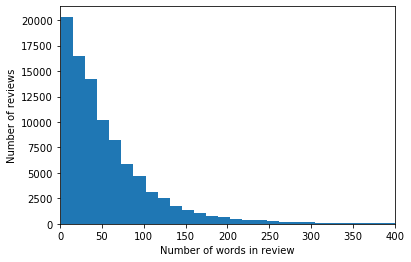

In [15]:
ax = reviews['word_count'].plot.hist(bins=100)
ax.set_xlim(0, 400)
ax.set_xlabel(r'Number of words in review')
ax.set_ylabel(r'Number of reviews')

Text(0, 0.5, 'Number of reviews')

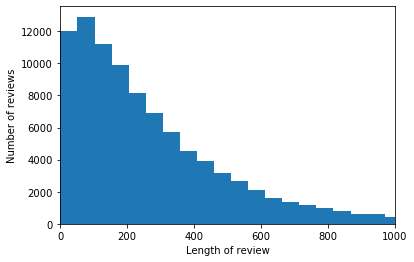

In [16]:
ax = reviews['review_length'].plot.hist(bins=150)
ax.set_xlim(0, 1000)
ax.set_xlabel(r'Length of review')
ax.set_ylabel(r'Number of reviews')

In [17]:
# This is the number of reviews per product
reviews.groupby('id')["content"].count()
# This is the number of total reviews
print(len(reviews["content"]))

94414


In [18]:
# Let's make input for the w2v model
sentences = []
for i in range(0, len(reviews['lemmatized'])):
    sentences.append(reviews['lemmatized'].iloc[i])
    
for i in range(0, 5):
    print(sentences[i])
    print("")
    
type(sentences[0])

['fabric', 'pleather', 'chair', 'tear', 'month', 'daily', 'use', 'super', 'comfortable', 'relatively', 'easy', 'assemble', 'really', 'enjoy', 'time', 'function', 'would', 'like', 'return', 'product', 'ship', 'especially', 'pandemic', 'never', 'write', 'review', 'purchase', 'end', 'bummer', 'give', 'money', 'back', 'without', 'return', 'mr', 'bezos', 'send', 'new', 'chair']

['receive', 'chair', 'part', 'assembly', 'zipper', 'back', 'unfortunately', 'make', 'little', 'sense', 'unzip', 'back', 'notice', 'one', 'zipper', 'teeth', 'miss', 'subsequently', 'zipper', 'go', 'track', 'come', 'apart', 'continue', 'put', 'chair', 'together', 'figure', 'would', 'try', 'deal', 'zipper', 'later', 'chair', 'simple', 'assemble', 'however', 'take', 'lot', 'finagle', 'get', 'zipper', 'back', 'together', 'still', 'require', 'dab', 'glue', 'keep', 'hold', 'wonder', 'return', 'chair', 'take', 'weeks', 'get', 'first', 'place', 'want', 'wait', 'exchange', 'need', 'office', 'chair', 'really', 'hop', 'better',

list

In [19]:
# Okay, now the data is cleaned up, we can begin with word2vec
model = gensim.models.Word2Vec(sentences, min_count=25, window=5, size=100)
# size      : should be low (~100) if you don't have much data and large (~1000) if you have a lot of data
# window    : is how many words to search for a keyword
# min_count : the model will ignore words which do not appear at least this frequently 

In [20]:
%%capture
model.wv.vocab

In [21]:
# Just a few things to show what we can do with w2v
target = 'tool'
compare = 'hammer'
model.wv.most_similar(positive=target)
# model.wv.similarity(w1=target, w2=compare)

[('screwdriver', 0.7412434816360474),
 ('allen', 0.7031148076057434),
 ('wrench', 0.6777735352516174),
 ('ratchet', 0.6674381494522095),
 ('philips', 0.6345522999763489),
 ('phillips', 0.6343860030174255),
 ('screwdrivers', 0.6308040618896484),
 ('hex', 0.6282024383544922),
 ('driver', 0.6254466772079468),
 ('key', 0.5968596935272217)]

In [22]:
target_word = "build"
selected_words = [w[0] for w in model.wv.most_similar(positive=[target_word], topn=100)]
embeddings = [model.wv[w] for w in selected_words]

mapped_embeddings = TSNE(n_components=2, metric='cosine', init='pca').fit_transform(embeddings)

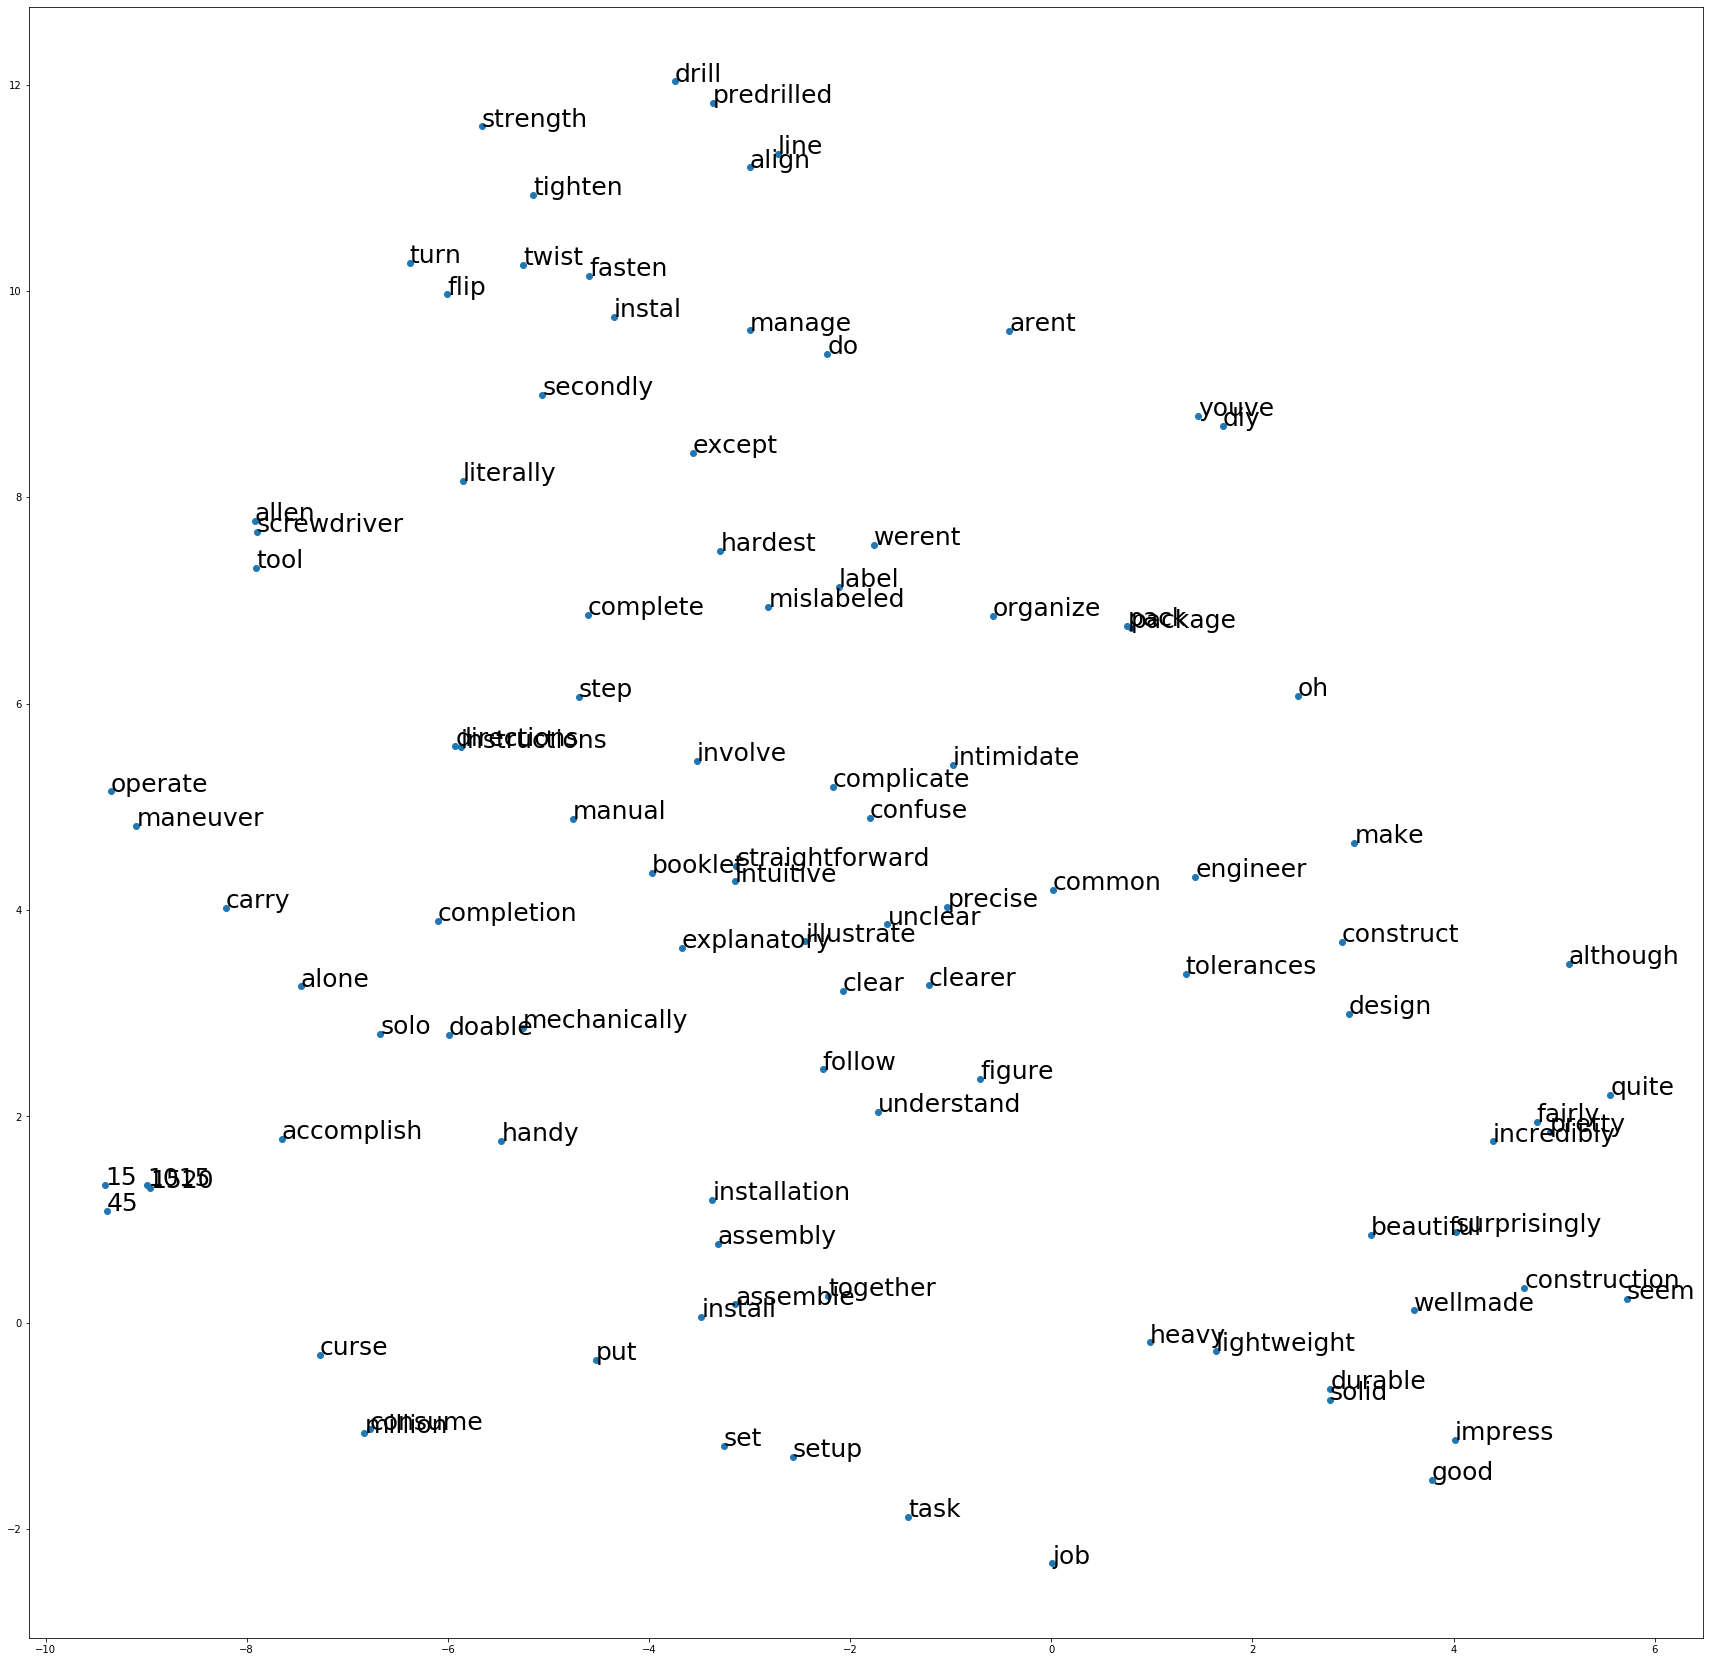

In [23]:
plt.figure(figsize=(30,30))
x = mapped_embeddings[:,0]
y = mapped_embeddings[:,1]
plt.scatter(x, y)

for i, txt in enumerate(selected_words):
    plt.annotate(txt, (x[i], y[i]), size=25)

In [24]:
# Let's import our labeled sentence dataset
semi_labeled_sentence_xl = data_directory + "sentence_rating.xlsx"
semi_labeled_sentences = pd.read_excel(semi_labeled_sentence_xl, sheet_name='Sheet1')

display(semi_labeled_sentences)

,Sentence,assembly,rate_ease,quality,rate_quality
0,Disappointed.,0.0,NaN,0.0,NaN
1,"Specifically, the bottom of the drawer is thin...",0.0,NaN,0.0,NaN
2,It was easy to put together with clear instruc...,1.0,5.0,0.0,NaN
3,I would buy this again in a heart beat.,0.0,NaN,0.0,NaN
4,The product looks like it could fall apart if ...,0.0,NaN,1.0,1.0
...,...,...,...,...,...
9995,If you need a couch ASAP and are in a budget.....,NaN,NaN,NaN,NaN
9996,Would recommend.,NaN,NaN,NaN,NaN
9997,Only had it for two months.,NaN,NaN,NaN,NaN
9998,Just the right size and shape for my living room.,NaN,NaN,NaN,NaN


In [25]:
# Let's clean this
# Apply the cleaning functions
semi_labeled_sentences['length'] = semi_labeled_sentences['Sentence'].astype(str).apply(len)
semi_labeled_sentences['word_count'] = semi_labeled_sentences['Sentence'].apply(lambda x: len(str(x).split()))
semi_labeled_sentences['no_dashes'] = semi_labeled_sentences['Sentence'].apply(lambda x: remove_dash(x))
semi_labeled_sentences['lower_case'] = semi_labeled_sentences['no_dashes'].apply(lambda x: x.lower())
semi_labeled_sentences['no_punctuation'] = semi_labeled_sentences['lower_case'].apply(lambda x: remove_punctuation(x))
# reviews['no_stops'] = reviews['no_punctuation'].apply(lambda x: remove_stopwords(x))
semi_labeled_sentences['tokenized'] = semi_labeled_sentences['no_punctuation'].apply(lambda x: tokenize(x))
semi_labeled_sentences['no_stops'] = semi_labeled_sentences['tokenized'].apply(lambda x: remove_stopwords(x))
semi_labeled_sentences['lemmatized'] = semi_labeled_sentences['no_stops'].apply(lambda x: lemmatize_text(x))

In [26]:
# Get a dataframe of only the labeled sentences
labeled_sentences = semi_labeled_sentences.dropna(subset = ["assembly"])
# Remove any rows that have no text
del_indices = []
for i in range(0, len(labeled_sentences["lemmatized"])):
    if len(labeled_sentences["lemmatized"].iloc[i]) == 0:
        del_indices.append(i)
        
# Loop through in reverse order to delete indices
labeled_sentences.drop(labeled_sentences.index[del_indices], inplace=True)
    
# Get the "assembly" and "lemmatized" categories from this data
cols = ['assembly', 'lemmatized']
labeled = labeled_sentences[cols]

display(labeled)

,assembly,lemmatized
0,0.0,[disappoint]
1,0.0,"[specifically, bottom, drawer, thinner, bottom..."
2,1.0,"[easy, put, together, clear, instructions, par..."
3,0.0,"[would, buy, heart, beat]"
4,0.0,"[product, look, like, could, fall, apart, scre..."
...,...,...
494,0.0,"[husband, work, home, multiple, occasion, try,..."
495,0.0,"[chair, short]"
496,0.0,"[use, massage, room, entry, clients, place, be..."
497,0.0,"[great, chair]"


In [ ]:
# Same as above without numpy
def word_averaging(wv, sentence):
    all_words, mean = set(), []
    # Loop through each word in the sentence
    for word in sentence:
        if word in wv.vocab:
            # This works for data-trained
            mean.append(wv.vectors_norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)
    # Check if mean is empty
    if not mean:
        return [0. for i in range(wv.vector_size)]
        
    # Creat a list that sums the vectors
    sum_vec = [0. for i in range(len(mean[0]))]
    for i in range(0, len(mean)):
        for j in range(0, len(mean[0])):
            sum_vec[j] += mean[i][j]
            
    # Divide by the number of vectors that were added
    mean_vec = [ i / float(len(mean)) for i in sum_vec]
            
    # Get the magnitude
    mag = 0.
    for i in sum_vec:
        mag += (i**2.)
        
    # Compute the unit vector
    mean_unit_vec = [ i / float(mag**0.5) for i in mean_vec ]

    return mean_unit_vec

In [ ]:
print(word_averaging(pre_trained_model.wv, test))

I am planning to use BERT here BUT I don't quite have time for that before the MVP is due...

In [ ]:
# We need a model which is embedded on the train set
import torch
from pytorch_pretrained_bert import BertModel, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# I'm going to use pre-trained w2v this time around
import gensim.downloader as api
corpus = api.load('text8')

In [ ]:
# Load the pre-trained model in
pre_trained_model = gensim.models.Word2Vec(corpus)

In [ ]:
pre_trained_model.init_sims(replace=True)
pre_trained_model.wv.vectors_norm[0]

In [ ]:
sentence_means = []
for i in range(0, len(labeled['lemmatized'])):
    # This is trained on my amazon data
#     sentence_mean = word_averaging(model.wv, labeled['lemmatized'].iloc[i])
#     sentence_means.append(sentence_mean)
    # This is the pretrained model
    sentence_mean = word_averaging(pre_trained_model.wv, labeled['lemmatized'].iloc[i])
    sentence_means.append(sentence_mean)

labeled['means'] = sentence_means
display(labeled)

In [ ]:
# I'll split this into train (90%) and test (10%) now
X_train, X_test, y_train, y_test = train_test_split(labeled['means'], labeled['assembly'], test_size=0.1, random_state=42)

print(type(X_train))
print(X_train[1])

In [ ]:
logreg = LogisticRegression(n_jobs=1)
# This give our logistic regression fit to the training data
logreg = logreg.fit(X_train.tolist(), y_train)

# We can see how the test data matches up
predicted = logreg.predict(X_test.tolist())
actual_y = y_test.tolist()

# Number correct and incorrect
correct = 0
incorrect = 0
for i in range(0, len(predicted)):
    if predicted[i] == actual_y[i]:
        correct += 1
    else:
        incorrect += 1
percent_correct = float(correct) / len(actual_y) * 100.
        
print(f"Model accuracy: {percent_correct}%")

In [ ]:
import joblib

# Let's save our pre-trained model
pre_trained_model.save('pre_trained_w2v.model')
# And our logistic regression
logreg_out = 'pre_trained_w2v_logistic_regression.pkl'
joblib.dump(logreg, logreg_out)

# with open('pre_trained_w2v_logistic_regression.pkl', 'wb') as file:
#     pickle.dump(logreg, file)
    
# pickle.dump(logreg, open('pre_trained_w2v_logistic_regression.sav', 'wb'))

In [ ]:
# Add labeled columns
sentence_df['assembly'] = None
sentence_df['rate_ease'] = None
sentence_df['quality'] = None
sentence_df['rate_quality'] = None

display(sentence_df)

In [ ]:
# I can also use this to reinsert my prelabeled values
match_index = []
for i in range(0, len(labeled_sentences['assembly'])):
    # This gives me the matching index so we can fill known values
    match = sentence_df[sentence_df['sentence'] == labeled_sentences['Sentence'].iloc[i]].index.values
    # Add the manually labeled values to the complete data frame
    sentence_df['assembly'].iloc[match] = labeled_sentences['assembly'].iloc[i]
    sentence_df['rate_ease'].iloc[match] = labeled_sentences['rate_ease'].iloc[i]
    sentence_df['quality'].iloc[match] = labeled_sentences['quality'].iloc[i]
    sentence_df['rate_quality'].iloc[match] = labeled_sentences['rate_quality'].iloc[i]
    

In [ ]:
# Use your logistic regression to label all the other sentences
labeled_value = []
labeled_index = []
means = []
for i in range(0, len(sentence_df['assembly'])):
    # If it is already labeled then skip it (it was manually labeled)
    if sentence_df['assembly'].iloc[i] != None:
        labeled_value.append(sentence_df['assembly'].iloc[i])
        labeled_index.append(i)
    # Vectorize the sentence and take the mean
    sentence_mean = word_averaging(pre_trained_model.wv, sentence_df['lemmatized'].iloc[i])
    means.append(sentence_mean)

# Predict if sentence is or isn't an assembly sentence
predicted = logreg.predict(means)

In [ ]:
# Revert manually labeled sentences
for i in range(0, len(labeled_index)):
    predicted[labeled_index[i]] = labeled_value[i]
    
# Replace column in dataframe
assembly = {'assembly': predicted}
assembly_df = pd.DataFrame(assembly)
sentence_df['assembly'] = assembly_df

In [ ]:
# This is how many sentences are about assembly
sentence_df['assembly'].sum()

In [ ]:
# Let's take a look at only the subset of sentences that mention assembly
assembly = sentence_df[sentence_df['assembly'] == 1]
display(assembly)

Again, this will eventually be BERT but for now, VADER

In [ ]:
# Okay, now we layer a sentiment analysis on this
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def get_sentiment(sentence):
    '''Assign sentiment to any give sentence using VADER'''
    # Instantiate the sentiment analyzer
    sentiment = SentimentIntensityAnalyzer()
    # Get the sentiment dictionary for my sentence
    sentiment_dict = sentiment.polarity_scores(sentence) 
    # Output the compound sentiment (between [-1, 1])
    out = sentiment_dict['compound']
    # Renormalize this to be [1, 5]
    stars = (out * 2.) + 3.
    return stars

In [ ]:
# Let's get a column of sentiment
assembly['assembly_stars'] = assembly['sentence'].apply(get_sentiment)

In [ ]:
display(assembly)

In [ ]:
minval = assembly['assembly_stars'].min()
print(minval)

In [ ]:
# Create a rounded column
assembly['assembly_stars_rounded'] = assembly['assembly_stars'].apply(round)
display(assembly)

In [ ]:
# What is the distribution of our star rating
assembly['assembly_stars'].iplot(kind='hist',
                            bins=5,
                            xTitle='Rating',
                            linecolor='black',
                            yTitle='Number of reviews',
                            title='Rating distribution')

In [ ]:
# What is the distribution of our star rating
assembly['rate_ease'].iplot(kind='hist',
                            bins=5,
                            xTitle='Rating',
                            linecolor='black',
                            yTitle='Number of reviews',
                            title='Rating distribution')

In [ ]:
# What's the average amount off (avg high and avg low)
assembly['assembly_rate_diff'] = assembly['rate_ease'] - assembly['assembly_stars_rounded'] 

bins = np.arange(-3,5,1)-0.5
print(bins)
ax = assembly['assembly_rate_diff'].plot.hist(bins=bins)
# ax.set_xlim(-3, 3)
ax.set_xlabel(r'Labeled rating - predicted rating')
ax.set_ylabel(r'Number of ratings')